# Data-based Systems Results analysis

In this notebook we are going to analyze the runs of the best data-based system ([d] configuration). Our best system is obtained with the Stream Parsing configuration (Jena + LightRDF) with triple deduplication and by using the Lucene Tokenizer and the NLTK Stoplist. In order to see what we are missing with respect to the data-based system developed by ACORDAR we are going to do the following analysis:
- Failure Analysis 
- Paired T-Test in order to see if the run is different with the ACORDAR one
- Impact of empty datasets
- Impact of partial datasets
- Difference between my runs and acordar ones in order to see ranks and scores differences

All the analysis will be conduced by using the the run files, and score files geenrated by using the <code>generate_scores.py</code> script. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

dirname = os.path.dirname(__name__)

## 1. Failure Analysis

Let's do a failure analysis in order to have a global vision of the performances of the 2 systems.

In [3]:
title_pad = 20
title_dim = 'xx-large'
xy_pad = 12
xy_label_dim = 'large'
figure_size = (20, 10)

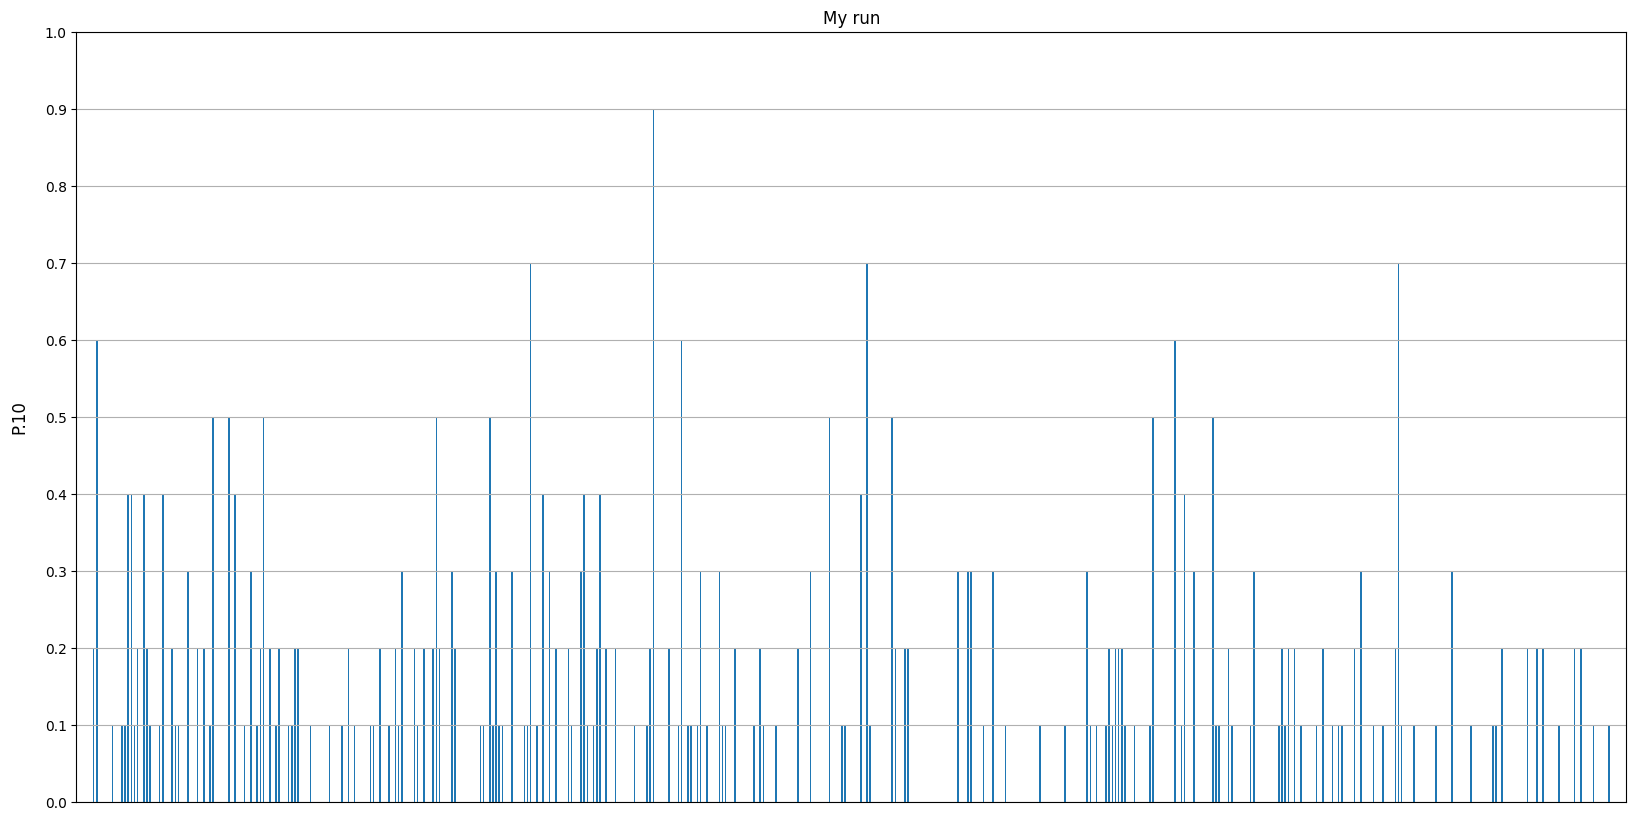

In [4]:
filecsv_myscores = os.path.join(dirname, "../../files/run/ARDFS/Stream_Jena_LightRDF_Deduplication/scores/FSDM[d].csv")


my_df = pd.read_csv(filecsv_myscores, sep = ',')

my_df.drop(my_df.tail(1).index,inplace=True)

plt.rcParams["figure.figsize"] = figure_size

#Bar plot
my_df.plot(kind='bar',x='query_id',y='score',legend=None)
axes = plt.gca()
axes.yaxis.grid()
axes.get_xaxis().set_visible(False)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('P.10', labelpad=xy_pad, fontsize=xy_label_dim)
plt.title("My run")
plt.show()
     


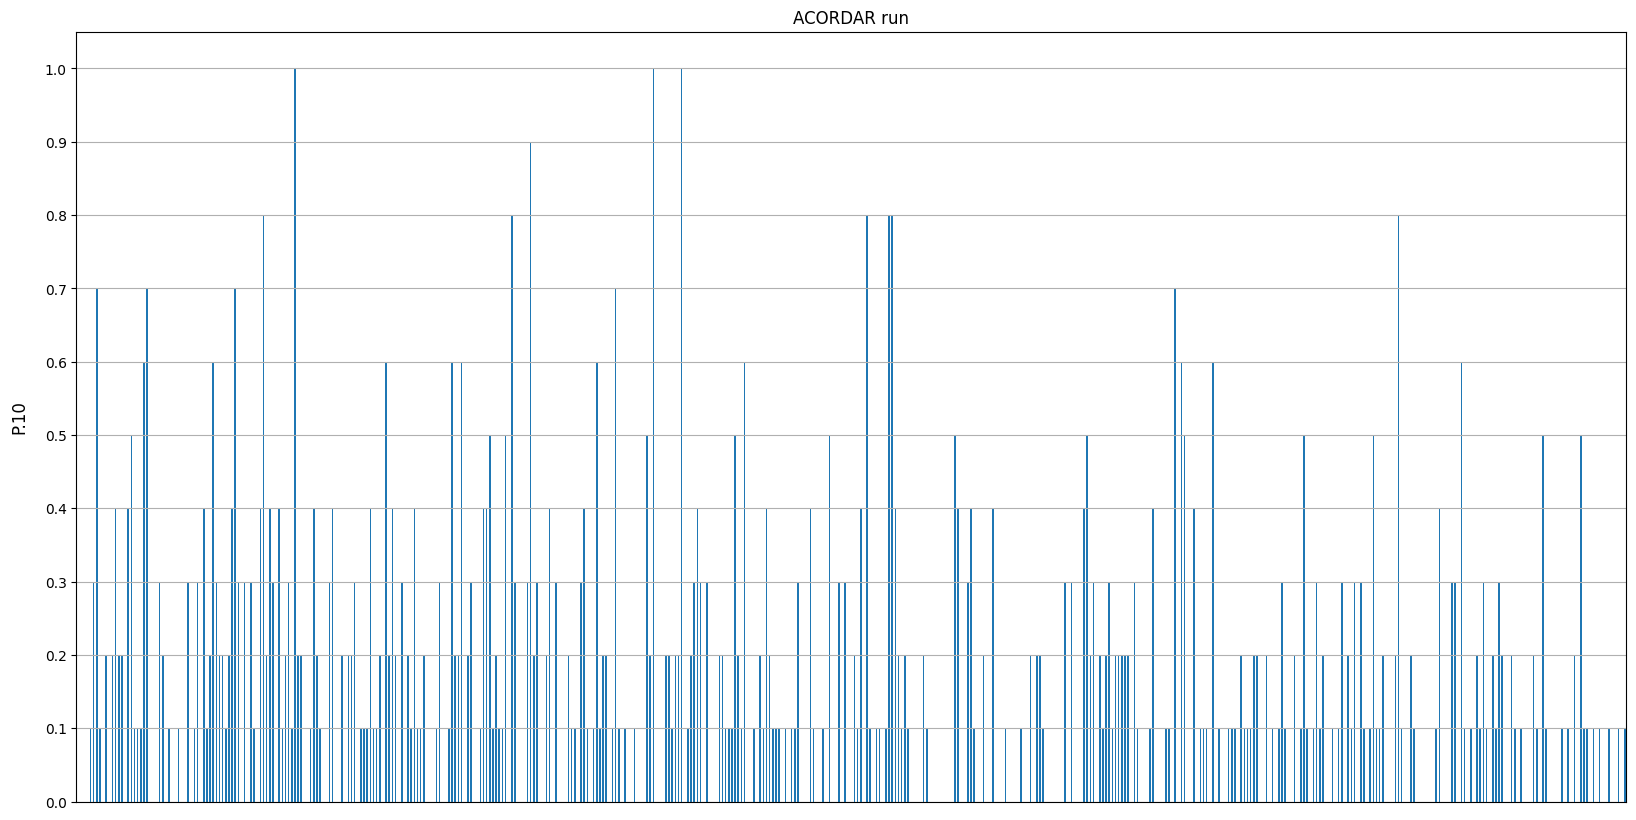

In [5]:
filecsv_acordar = os.path.join(dirname, "../../files/run/ACORDAR/scores/FSDM[d].csv")
df_acordar = pd.read_csv(filecsv_acordar, sep = ',')

df_acordar.drop(df_acordar.tail(1).index,inplace=True)

plt.rcParams["figure.figsize"] = figure_size

#Bar plot
df_acordar.plot(kind='bar',x='query_id',y='score',legend=None)
axes = plt.gca()
axes.yaxis.grid()
axes.get_xaxis().set_visible(False)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('P.10', labelpad=xy_pad, fontsize=xy_label_dim)
plt.title("ACORDAR run")

plt.show()
     


## 2. Paired T-Test

From the above charts we can see that the two runs have different trends. We do a Paired T-Test in order to see if the two runs are effectively different. 


In [7]:
import scipy.stats as stats

acordar_scores = df_acordar["score"]
my_scores = my_df["score"]

stats.ttest_rel(acordar_scores, my_scores)

TtestResult(statistic=11.814136474224698, pvalue=1.5833719085216242e-28, df=492)

the p-value is much lower than 0.05 so we accept the hypothesis that the two runs are different.

## 3. Impact of Empty Datasets

Since during the download and parsing phases we are losing some files because of download and parsing errors, now we are going to consider the impact of the empty datasets (datasets without a parsed file). 

In [8]:
#create two maps query_id -> score for my scores and acordar scores

acordar_scores_map = dict()
my_scores_map = dict()

queries_ids = my_df["query_id"].tolist()
for i in range(len(queries_ids)):
    acordar_scores_map[int(queries_ids[i])] = acordar_scores[i]
    my_scores_map[int(queries_ids[i])] = my_scores[i]


In [2]:
#let's build a simple query -> query_text map

queries_file = open(os.path.join(dirname, "../../files/all_queries.txt"), "r")
queries_text = dict()

while True:
    line = queries_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    text = split[1].strip()

    queries_text[query_id] = text
queries_file.close()


NameError: name 'os' is not defined

In [1]:
#build the qrels map. query_id -> dataset_id -> relevance

qrels = dict()

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"), "r")

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if query_id not in qrels:
        qrels[query_id] = dict()

    qrels[query_id][dataset_id] = rel
qrels_file.close()

NameError: name 'os' is not defined

In [11]:
#load my ranks and acordar ones for all the queries in order to see a diff

def generate_ranks(run_file):
    ranks = dict()
    ranks_with_rel = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])

        if query_id not in ranks.keys():
            ranks[query_id] = list()
            ranks_with_rel[query_id] = list()

        #recover the relevance scores
        rel = None
        if query_id in qrels.keys():
            if dataset_id in qrels[query_id].keys():
                rel = qrels[query_id][dataset_id]
        
        ranks_with_rel[query_id].append((dataset_id, rel))
        ranks[query_id].append(dataset_id) 
    
    return ranks, ranks_with_rel

acordar_run = open(os.path.join(dirname, "../../files/run/ACORDAR/FSDM[d].txt"), "r")
my_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Jena_LightRDF_Deduplication/FSDM[d].txt"), "r")

acordar_ranks,acordar_ranks_with_rel = generate_ranks(acordar_run)
my_ranks, my_ranks_with_rel = generate_ranks(my_run)

acordar_run.close()
my_run.close()

In [12]:
#open the empty datasets json list file
empty_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/stream/empty_datasets_standard.json"), "r")
empty_datasets_set = json.load(empty_datasets_file)
empty_datasets_set = set(empty_datasets_set)
empty_datasets_file.close()

#open the full datasets json list file
full_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/stream/full_datasets_standard.json"), "r")
full_datasets_set = json.load(full_datasets_file)
full_datasets_set = set(full_datasets_set)
full_datasets_file.close()

#open the partial datasets json list file
partial_datasets_file = open(os.path.join(dirname, "../../files/datasets_lists/stream/partial_datasets_standard.json"), "r")
partial_datasets_set = json.load(partial_datasets_file)
partial_datasets_set = set(partial_datasets_set)
partial_datasets_file.close()

In [13]:
#we have to filter only the empty, partial and full datasets that are relevant for some queries

qrels_file = open(os.path.join(dirname, "../../files/qrels.txt"), "r")
query_empty_relevant_datasets = dict()
query_partial_relevant_datasets = dict()
query_full_relevant_datasets = dict()

while True:
    line = qrels_file.readline()

    if not line:
        break

    split = line.split("\t")
    query_id = int(split[0])
    dataset_id = int(split[2])
    rel = int(split[3])

    if rel > 0 and dataset_id in empty_datasets_set:
        if query_id not in query_empty_relevant_datasets:
             query_empty_relevant_datasets[query_id] = set()
    
        query_empty_relevant_datasets[query_id].add(dataset_id)

    if rel > 0 and dataset_id in partial_datasets_set:   
        if query_id not in query_partial_relevant_datasets:
             query_partial_relevant_datasets[query_id] = set()
            
        query_partial_relevant_datasets[query_id].add(dataset_id)

    if rel > 0 and dataset_id in full_datasets_set:   
        if query_id not in query_full_relevant_datasets:
            query_full_relevant_datasets[query_id] = set()

        query_full_relevant_datasets[query_id].add(dataset_id)

qrels_file.close()
    

In [14]:
#generate a map query_id -> score acordar, my score, my rank, acordar rank, empty datasets in acordar rank

queries_score_ranks_empty = dict()

for query in queries_text.keys():
    acordar_rank = set(acordar_ranks[query])
    my_rank = set(my_ranks[query])

    intersection_empty = set()
    intersection_partial = set()
    intersection_full = set()
    
    if query in query_empty_relevant_datasets.keys():
        intersection_empty = query_empty_relevant_datasets[query].intersection(acordar_rank)
    
    if query in query_partial_relevant_datasets.keys():
        intersection_partial = query_partial_relevant_datasets[query].intersection(acordar_rank)

    if query in query_full_relevant_datasets.keys():
        intersection_full = query_full_relevant_datasets[query].intersection(acordar_rank)
        
    common_datasets = acordar_rank.intersection(my_rank)

    if query not in queries_score_ranks_empty.keys():
        queries_score_ranks_empty[query] = dict()

    queries_score_ranks_empty[query]["acordar_score"] = acordar_scores_map[query]
    queries_score_ranks_empty[query]["my_score"] = my_scores_map[query]
    queries_score_ranks_empty[query]["acordar_rank"] = acordar_ranks[query]
    queries_score_ranks_empty[query]["acordar_rank_with_rel"] = acordar_ranks_with_rel[query]
    queries_score_ranks_empty[query]["my_rank"] = my_ranks[query]
    queries_score_ranks_empty[query]["my_rank_with_rel"] = my_ranks_with_rel[query]
    queries_score_ranks_empty[query]["empty_datasets"] = intersection_empty
    queries_score_ranks_empty[query]["partial_datasets"] = intersection_partial
    queries_score_ranks_empty[query]["full_datasets"] = intersection_full
    queries_score_ranks_empty[query]["common_datasets"] = common_datasets
    

In [15]:
#print the details about queries where acordar returns empty datasets

i = 0 
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["empty_datasets"]) > 0:
        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Relevant Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Relevant Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
        print(f"Relevant Full datasets: {queries_score_ranks_empty[query]['full_datasets']}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print()
        i+=1
print(i)

2 Acquisitions
A: 0.5 M: 0.4
A: [(4594, 1), (49347, 1), (2445, 1), (2614, 1), (2330, None), (2517, None), (50677, 1), (50686, None), (2293, None), (50690, None)]
M: [(49347, 1), (2445, 1), (2614, 1), (2330, None), (2517, None), (50686, None), (50677, 1), (2293, None), (50690, None), (50718, None)]
Relevant Empty datasets: {4594}
Relevant Partial datasets: set()
Relevant Full datasets: {50677, 49347, 2445, 2614}
Common datasets: {50690, 49347, 2445, 2517, 2614, 50677, 2293, 2330, 50686}

19 Who's working with Supercomputers
A: 0.1 M: 0.1
A: [(13284, 0), (14417, 0), (13013, 1), (12570, 0), (3914, None), (8885, None), (7107, None), (74835, None), (15156, None), (11053, None)]
M: [(13013, 1), (14417, 0), (13284, 0), (12570, 0), (15156, None), (15641, None), (1664, None), (18724, None), (18248, None), (1889, None)]
Relevant Empty datasets: {13013}
Relevant Partial datasets: set()
Relevant Full datasets: set()
Common datasets: {13284, 14417, 15156, 13013, 12570}

22 MCI
A: 0.2 M: 0.0
A: [(26

In order to see if the empty datasets have an impact in the system performances we follow the following idea: if empty datasets not returned in my runs can improve the P10 and reach the ACORDAR P10 for that query, I substitute the P10 score for that query with the ACORDAR one. Then I calculate the new total P10 for the query, in order to see if he have an improvement.

In [18]:
my_scores_map_new = my_scores_map.copy()

for query in queries_score_ranks_empty.keys():
    if queries_score_ranks_empty[query]["my_score"] + (len(queries_score_ranks_empty[query]["empty_datasets"]) / 10) == queries_score_ranks_empty[query]["acordar_score"]:
        my_scores_map_new[query] = queries_score_ranks_empty[query]["acordar_score"]

score_new = 0
score_old = 0
score_acordar = 0
for query in my_scores_map_new.keys():
    score_new += my_scores_map_new[query]
    score_old += my_scores_map[query]
    score_acordar += acordar_scores_map[query]

print(f"Old P10: {score_old/len(my_scores_map.keys())}") 
print(f"New P10: {score_new/len(my_scores_map.keys())}") 
print(f"ACORDAR P10: {score_acordar/len(my_scores_map.keys())}") 

Old P10: 0.0758620689655174
New P10: 0.08559837728194747
ACORDAR P10: 0.15152129817444213


In [23]:
#print the query details where the P@10 value is 0

i = 0 
for query in queries_score_ranks_empty.keys():
    if queries_score_ranks_empty[query]['my_score'] == 0 and queries_score_ranks_empty[query]['acordar_score'] > 0:
        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Relevant Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Relevant Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
        print(f"Relevant Full datasets: {queries_score_ranks_empty[query]['full_datasets']}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print()
        i+=1
print(i)

5 U.S. Budget Deficit
A: 0.3 M: 0.0
A: [(14979, 0), (3914, 1), (9547, 1), (55773, 1), (47956, 0), (32557, None), (71076, 0), (5216, None), (1796, None), (54961, None)]
M: [(14979, 0), (9422, None), (32578, None), (9449, None), (32576, None), (63551, None), (14977, None), (32590, None), (14079, None), (14530, None)]
Relevant Empty datasets: set()
Relevant Partial datasets: set()
Relevant Full datasets: {3914, 9547, 55773}
Common datasets: {14979}

22 MCI
A: 0.2 M: 0.0
A: [(2690, 1), (44849, 0), (6475, 1), (30519, 0), (10260, 0), (10527, 0), (43248, 0), (3575, 0), (63195, 0), (9464, 0)]
M: [(9927, None), (11323, None), (54259, None), (63232, None), (8681, None), (16581, None), (7570, None), (66543, None), (31244, None), (7177, None)]
Relevant Empty datasets: {2690}
Relevant Partial datasets: set()
Relevant Full datasets: {6475}
Common datasets: set()

27 Natural Language Processing
A: 0.1 M: 0.0
A: [(12513, 1), (21537, None), (21539, None), (21536, None), (14631, None), (10280, None), (2

from this simple analysis we can see that the increment of the P@10 is of 0.01 points, so the empty datasets are not affecting the results too much

## 4.0 Impact of Partial Datasets

Since during the download and parsing phases we are losing some files because of download and parsing errors, now we are going to consider the impact of the partial datasets (datasets without at least one parsed file). 

In [19]:
#load the more fine grained stats about partial datasets
fine_grained_partial_list_json = open(os.path.join(dirname, "../../files/datasets_lists/stream/partial_datasets_stream_fine.json"), "r")
fine_grained_partial_list = json.load(fine_grained_partial_list_json)

In [20]:
#print details about queries where acordar not returns empty datasets but returns partial datasets

i=0
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["partial_datasets"]) > 0:
        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
        print(f"How much partial: ")
        for dataset in queries_score_ranks_empty[query]['partial_datasets']:
            print(f"dataset-{dataset}: {fine_grained_partial_list[str(dataset)]}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print()
        i+=1
print(i)

33 Greenpeace
A: 0.8 M: 0.7
A: [(30716, 0), (14976, 1), (30780, 0), (30801, 1), (30883, 1), (3850, 1), (43918, 1), (4578, 1), (55340, 1), (24412, 1)]
M: [(30716, 0), (14976, 1), (30780, 0), (30801, 1), (4578, 1), (30883, 1), (24412, 1), (43918, 1), (3850, 1), (14925, 0)]
Empty datasets: set()
Partial datasets: {14976}
How much partial: 
dataset-14976: 0.5
Common datasets: {14976, 4578, 30883, 3850, 30716, 30780, 43918, 30801, 24412}

60 Death from Cancer
A: 0.2 M: 0.1
A: [(13284, 1), (14417, 0), (29330, None), (42024, None), (3060, None), (2840, None), (9526, None), (9862, None), (9897, None), (42209, 2)]
M: [(14417, 0), (13284, 1), (14079, None), (14298, None), (13360, None), (1889, None), (71080, None), (14252, None), (14530, None), (14084, None)]
Empty datasets: set()
Partial datasets: {13284}
How much partial: 
dataset-13284: 0.07692307692307693
Common datasets: {14417, 13284}

61 RDT&E of New Cancer Fighting Drugs
A: 0.1 M: 0.1
A: [(13284, 0), (14417, 1), (45518, 0), (53752, 0), (

In [26]:
#print details about queries where all the partial datasets are not returned by the reproduced system

i=0
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["partial_datasets"]) > 0:
        if not queries_score_ranks_empty[query]["partial_datasets"].issubset(queries_score_ranks_empty[query]['common_datasets']):
            print(f"{query} {queries_text[query]}")
            print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
            print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
            print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
            print(f"Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
            print(f"Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
            print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
            print()
            i+=1
print(i)

134 Endangered Species (Mammals)
A: 0.5 M: 0.4
A: [(23318, 1), (23313, 0), (23297, 1), (23352, None), (23345, 1), (13347, 1), (14324, 0), (7075, None), (12513, 0), (85975, 2)]
M: [(23318, 1), (23297, 1), (23352, None), (23337, None), (23313, 0), (23345, 1), (4784, 2), (14252, None), (13378, None), (43448, None)]
Empty datasets: {85975}
Partial datasets: {13347}
Common datasets: {23297, 23313, 23345, 23318, 23352}

204 steel production
A: 0.1 M: 0.0
A: [(13356, 1), (63887, 0), (8847, None), (10017, None), (63844, 0), (9523, None), (74594, None), (2488, None), (48628, None), (4711, None)]
M: [(63887, 0), (8847, None), (74594, None), (10017, None), (11143, None), (63844, 0), (9523, None), (48628, None), (2488, None), (4711, None)]
Empty datasets: set()
Partial datasets: {13356}
Common datasets: {10017, 74594, 63844, 4711, 8847, 63887, 9523, 48628, 2488}

1023 species relationships, RDF dump files.
A: 0.2 M: 0.2
A: [(21536, None), (12518, None), (21538, None), (562, None), (13283, 2), (142

In [27]:
#print details about queries where acordar not returns empty datasets but returns partial datasets

i=0
for query in queries_score_ranks_empty.keys():
    if len(queries_score_ranks_empty[query]["partial_datasets"]) > 0:
        #retrieve positions in rank for every partial dataset 
        positions = dict()
        for dataset in queries_score_ranks_empty[query]['partial_datasets']:
            p_a = queries_score_ranks_empty[query]['acordar_rank'].index(dataset) + 1
            if dataset in queries_score_ranks_empty[query]['my_rank']:
                p_r = queries_score_ranks_empty[query]['my_rank'].index(dataset) + 1
            else:
                p_r = 11
            positions[dataset] = p_r - p_a 

        print(f"{query} {queries_text[query]}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_score']} M: {queries_score_ranks_empty[query]['my_score']}")
        print(f"A: {queries_score_ranks_empty[query]['acordar_rank_with_rel']}")
        print(f"M: {queries_score_ranks_empty[query]['my_rank_with_rel']}")
        print(f"Empty datasets: {queries_score_ranks_empty[query]['empty_datasets']}")
        print(f"Partial datasets: {queries_score_ranks_empty[query]['partial_datasets']}")
        print(f"How much partial: ")
        for dataset in queries_score_ranks_empty[query]['partial_datasets']:
            print(f"dataset-{dataset}: {fine_grained_partial_list[str(dataset)]}")
        print(f"Common datasets: {queries_score_ranks_empty[query]['common_datasets']}")
        print(positions)
        print()
        i+=1
print(i)

33 Greenpeace
A: 0.8 M: 0.7
A: [(30716, 0), (14976, 1), (30780, 0), (30801, 1), (3850, 1), (43918, 1), (30883, 1), (4578, 1), (55340, 1), (24412, 1)]
M: [(14976, 1), (30716, 0), (30780, 0), (30801, 1), (43918, 1), (3850, 1), (4578, 1), (30883, 1), (24412, 1), (14925, 0)]
Empty datasets: set()
Partial datasets: {14976}
How much partial: 
dataset-14976: 0.5
Common datasets: {14976, 4578, 30883, 3850, 30716, 43918, 30780, 30801, 24412}
{14976: -1}

60 Death from Cancer
A: 0.1 M: 0.1
A: [(13284, 1), (14417, 0), (4594, None), (29330, None), (12513, None), (74827, None), (3578, None), (45431, None), (845, None), (30449, None)]
M: [(14417, 0), (13284, 1), (74827, None), (3578, None), (45431, None), (30449, None), (4675, None), (845, None), (9526, None), (13579, None)]
Empty datasets: set()
Partial datasets: {13284}
How much partial: 
dataset-13284: 0.07692307692307693
Common datasets: {13284, 74827, 845, 14417, 30449, 45431, 3578}
{13284: 1}

61 RDT&E of New Cancer Fighting Drugs
A: 0.1 M: 0.

## Output Scores

In [40]:
#load my ranks and acordar ones for all the queries in order to see a diff

def generate_ranks_with_scores(run_file):
    ranks = dict()

    while True:
        line = run_file.readline()

        if not line:
            break

        split = line.split("\t")
        query_id = int(split[0])
        dataset_id = int(split[2])
        score = float(split[4])

        if query_id not in ranks.keys():
            ranks[query_id] = dict()

        ranks[query_id][dataset_id] = score
    
    return ranks

acordar_run = open(os.path.join(dirname, "../../files/run/ACORDAR/BM25F[d].txt"), "r")
my_run = open(os.path.join(dirname, "../../files/run/ARDFS/Stream_Jena_LightRDF_Deduplication_Labels/BM25Boost[d].txt"), "r")

acordar_ranks = generate_ranks_with_scores(acordar_run)
my_ranks = generate_ranks_with_scores(my_run)

acordar_run.close()
my_run.close()

In [41]:
abs = 0
n = 0 
for query in queries_text.keys():
    acordar_rank = set(acordar_ranks[query].keys())
    my_rank = set(my_ranks[query].keys())

    #common datasets 
    common_datasets = acordar_rank.intersection(my_rank)

    #absolute difference
    for dataset in common_datasets:
        
        abs += acordar_ranks[query][dataset] - my_ranks[query][dataset]
    

    n += len(common_datasets)

print(abs/n)



0.8056369610797411
